In [1]:
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
#import utils
import torch.nn.functional as F

In [131]:
import torch
import torch.nn as nn
import torchvision.models as models
#import utils
import torch.nn.functional as F
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from transformers import (
    
    AutoTokenizer, AutoFeatureExtractor,
    
    AutoModel,            
    
    TrainingArguments, Trainer,
    
    logging
)
import nltk
import re

In [ ]:
pip install datasets

In [ ]:
pip install transformers


In [4]:
os.environ['HF_HOME'] = os.path.join(".", "cache")

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
batch=4
set_caching_enabled(True)
logging.set_verbosity_error()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

<ipython-input-4-99ca11586268>:5: FutureWarning: set_caching_enabled is deprecated and will be removed in the next major version of datasets. Use datasets.enable_caching() or datasets.disable_caching() instead. This function will be removed in a future version of datasets.
  set_caching_enabled(True)


In [5]:
dataset = load_dataset(
    "csv", 
    data_files={
        "train": os.path.join( "dataset", "data_train.csv"),
        "test": os.path.join( "dataset", "data_eval.csv")
    }
)

with open(os.path.join( "dataset", "answer_space.txt")) as f:
    answer_space = f.read().splitlines()

dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0]) # Select the 1st answer if multiple answers are provided
            for ans in examples['answer']
        ]
    },
    batched=True
)

dataset

Using custom data configuration default-6861faf1b71ec50b
Found cached dataset csv (/Users/soumya_patra/.cache/huggingface/datasets/csv/default-6861faf1b71ec50b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /Users/soumya_patra/.cache/huggingface/datasets/csv/default-6861faf1b71ec50b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-62a0d99aadfaeff9.arrow
Loading cached processed dataset at /Users/soumya_patra/.cache/huggingface/datasets/csv/default-6861faf1b71ec50b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-5f80b5ac79d5dc6d.arrow


DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 6795
    })
    test: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 5673
    })
})

In [6]:
from IPython.display import display

def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]
    if id == None:
        id = np.random.randint(len(data))
    image = Image.open(os.path.join( "dataset", "images", data[id]["image_id"] + ".png"))
    display(image)

    print("Question:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"], "(Label: {0})".format(data[id]["label"]))

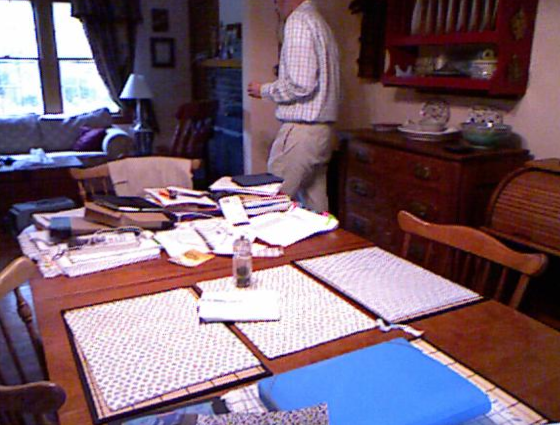

Question:	 what is on the sofa
Answer:		 pillow (Label: 383)


In [49]:
showExample()

In [8]:
@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor

    def tokenize_text(self, texts: List[str]):
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }

    def preprocess_images(self, images: List[str]):
        processed_images = self.preprocessor(
            images=[Image.open(os.path.join("dataset", "images", image_id + ".png")).convert('RGB') for image_id in images],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }
            
    def __call__(self, raw_batch_dict):
        return {
            **self.tokenize_text(
                raw_batch_dict['question']
                if isinstance(raw_batch_dict, dict) else
                [i['question'] for i in raw_batch_dict]
            ),
            **self.preprocess_images(
                raw_batch_dict['image_id']
                if isinstance(raw_batch_dict, dict) else
                [i['image_id'] for i in raw_batch_dict]
            ),
            'labels': torch.tensor(
                raw_batch_dict['label']
                if isinstance(raw_batch_dict, dict) else
                [i['label'] for i in raw_batch_dict],
                dtype=torch.int64
            ),
        }

In [7]:
'''def calculate(vec,k):
        x=torch.ones(vec.size())
        for i in range(vec.size()[0]):
            _,indices=torch.topk(vec[i],vec.size()[1]-k)
            for ind in indices: 
                x[i][ind]=0
        return x'''

In [34]:

class MANN(nn.Module):
    def __init__(self,batch,row,col,intermediate_dim):
        super(MANN,self).__init__()
        self.n=row
        self.m=col
        self.batch=batch
        self.memory=torch.rand((batch,row,col)
        self.lstm=nn.LSTM(input_size=intermediate_dim,hidden_size=col,num_layers=1,batch_first=True)
        #self.cosine=nn.CosineSimilarity()
        self.gamma=0.95
        self.wtlu=torch.rand((batch,row))
        self.wtu=torch.rand((batch,row))
        #self.wtw=torch.zeros(batch,row)
        self.wtr=torch.rand((batch,row))
        #self.h=torch.rand((1,batch,col),requires_grad=False)
        #print(self.h)
        #self.c=torch.rand((1,batch,col),requires_grad=False)
        self.alpha=torch.rand(1)
        self.n=4
    
    def calculate(self,vec,k):
        x=torch.ones(vec.size())
        for i in range(vec.size()[0]):
            _,indices=torch.topk(vec[i],vec.size()[1]-k)
            for ind in indices: 
                x[i][ind]=0
        return x
        
    def forward(self,vec):
        #print(vec.size())
        h1=torch.rand((1,self.batch,self.m))
        c1=torch.rand((1,self.batch,self.m))
        ot,(h,c)=self.lstm(vec.unsqueeze(1),(h1,c1))
        #self.h=h
        #self.c=c
        #print("ht=",ht.size())
        #print(ht.size(),ct.size())
        ht=h.squeeze()# B x M
#         print("ht=",ht.size())
#        ct=c.squeeze() #B x M
# #         #ot=B x M , 
#         #print(self.wtr.size())
        sigma=F.sigmoid(self.alpha)
        wtlu=self.calculate(self.wtu,self.n) 
        wtw=sigma*self.wtr+(1-sigma)*self.wtlu#B x N
        wtu=self.gamma*self.wtu+self.wtr+wtw
        self.wtu=wtu
        #wtlu=calculate(self.wtu,self.n)
        self.wtlu=wtlu
        self.wtr=F.softmax(F.cosine_similarity(ht.unsqueeze(1),self.memory,dim=2)) #B x N
        print(self.wtr.size())
        rt=torch.matmul(self.wtr.unsqueeze(1),self.memory).squeeze() #B x M
        memory=self.memory+torch.matmul(wtw.unsqueeze(1).permute(0,2,1),ht.unsqueeze(1)) # N x B . B x M  = N x M
        self.memory=memory
        #print(self.h.size(),rt.size())
        x=torch.cat((ht,rt),1)
        #print(x.size())
        return x
        
    

In [124]:
class MultimodalVQAModel(nn.Module):
    def __init__(
            self,
            num_labels: int = len(answer_space),
            intermediate_dim: int = 512,
            pretrained_text_name: str = 'bert-base-uncased',
            pretrained_image_name: str = 'google/vit-base-patch16-224-in21k'):
     
        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name
        self.row=128
        self.col=40
        
        self.text_encoder = AutoModel.from_pretrained(
            self.pretrained_text_name,
        )
        self.image_encoder = AutoModel.from_pretrained(
            self.pretrained_image_name,
        )
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        self.mann=MANN(batch,self.row,self.col,intermediate_dim=intermediate_dim)
        #self.classifier = nn.Linear(2*self.col, self.num_labels)
        
        self.classifier = nn.Linear(intermediate_dim, self.num_labels)
        
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):
        
        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )
        #print(fused_output.size())
        #output=self.mann(fused_output)
        #print(output.size())
        logits = self.classifier(fused_output)
        #logits = self.classifier(output)
        
        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss
        
        return out

In [125]:
collator, model, train_multi_metrics, eval_multi_metrics = createAndTrainModel(dataset, args)

loading configuration file config.json from cache at /Users/soumya_patra/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /Users/soumya_patra/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb42

{'loss': 6.1471, 'learning_rate': 4.941141848145969e-05, 'epoch': 0.06}


ValueError: not enough values to unpack (expected 2, got 1)

In [36]:
collator, model, train_multi_metrics, eval_multi_metrics = createAndTrainModel(dataset, args)

loading configuration file config.json from cache at /Users/soumya_patra/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /Users/soumya_patra/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb42

torch.Size([4, 512])
torch.Size([4, 128])
torch.Size([4, 80])


<ipython-input-34-62cecb9e0ecb>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.wtr=F.softmax(F.cosine_similarity(ht.unsqueeze(1),self.memory,dim=2)) #B x N


torch.Size([4, 512])
torch.Size([4, 128])
torch.Size([4, 80])


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
def createMultimodalVQACollatorAndModel(text='bert-base-uncased', image='google/vit-base-patch16-224-in21k'):
    tokenizer = AutoTokenizer.from_pretrained(text)
    preprocessor = AutoFeatureExtractor.from_pretrained(image)

    multi_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )


    multi_model = MultimodalVQAModel(pretrained_text_name=text, pretrained_image_name=image).to(device)
    return multi_collator, multi_model

In [13]:
def wup_measure(a,b,similarity_threshold=0.925):
    """
    Returns Wu-Palmer similarity score.
    More specifically, it computes:
        max_{x \in interp(a)} max_{y \in interp(b)} wup(x,y)
        where interp is a 'interpretation field'
    """
    def get_semantic_field(a):
        weight = 1.0
        semantic_field = wordnet.synsets(a,pos=wordnet.NOUN)
        return (semantic_field,weight)


    def get_stem_word(a):
        """
        Sometimes answer has form word\d+:wordid.
        If so we return word and downweight
        """
        weight = 1.0
        return (a,weight)


    global_weight=1.0

    (a,global_weight_a)=get_stem_word(a)
    (b,global_weight_b)=get_stem_word(b)
    global_weight = min(global_weight_a,global_weight_b)

    if a==b:
        # they are the same
        return 1.0*global_weight

    if a==[] or b==[]:
        return 0


    interp_a,weight_a = get_semantic_field(a) 
    interp_b,weight_b = get_semantic_field(b)

    if interp_a == [] or interp_b == []:
        return 0

    # we take the most optimistic interpretation
    global_max=0.0
    for x in interp_a:
        for y in interp_b:
            local_score=x.wup_similarity(y)
            if local_score > global_max:
                global_max=local_score

    # we need to use the semantic fields and therefore we downweight
    # unless the score is high which indicates both are synonyms
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score=global_max*weight_a*weight_b*interp_weight*global_weight
    return final_score 

In [14]:
def batch_wup_measure(labels, preds):
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)

In [15]:
def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    logits, labels = eval_tuple
    preds = logits.argmax(axis=-1)
    return {
        #"wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro')
    }

In [16]:
args = TrainingArguments(
    output_dir="checkpoint",
    seed=12345, 
    evaluation_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,             # Save only the last 3 checkpoints at any given time while training 
    #metric_for_best_model='wups',
    per_device_train_batch_size=batch,
    per_device_eval_batch_size=batch,
    remove_unused_columns=False,
    num_train_epochs=5,
    #fp16=True,
    # warmup_ratio=0.01,
    # learning_rate=5e-4,
    # weight_decay=1e-4,
    # gradient_accumulation_steps=2,
    #dataloader_num_workers=4,
    load_best_model_at_end=True,
)


In [17]:
def createAndTrainModel(dataset, args, text_model='bert-base-uncased', image_model='google/vit-base-patch16-224-in21k', multimodal_model='bert_vit'):
    collator, model = createMultimodalVQACollatorAndModel(text_model, image_model)
    
    multi_args = deepcopy(args)
    multi_args.output_dir = os.path.join("..", "checkpoint", multimodal_model)
    multi_trainer = Trainer(
        model,
        multi_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        data_collator=collator,
        compute_metrics=compute_metrics
    )
    
    train_multi_metrics = multi_trainer.train()
    eval_multi_metrics = multi_trainer.evaluate()
    
    return collator, model, train_multi_metrics, eval_multi_metrics

In [23]:
collator, model, train_multi_metrics, eval_multi_metrics = createAndTrainModel(dataset, args)

loading configuration file config.json from cache at /Users/soumya_patra/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /Users/soumya_patra/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb42

torch.Size([4, 512])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x512 and 80x582)

In [127]:
model

MultimodalVQAModel(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [123]:
collator, model =createMultimodalVQACollatorAndModel('bert-base-uncased','google/vit-base-patch16-224-in21k')

loading configuration file config.json from cache at /Users/soumya_patra/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /Users/soumya_patra/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb42

In [ ]:
eval_multi_metrics

In [ ]:

image_pattern = re.compile("( (in |on |of )?(the |this )?(image\d*) \?)")

with open(os.path.join("dataset", "all_qa_pairs.txt")) as f:
    qa_data = [x.replace("\n", "") for x in f.readlines()]

df = pd.DataFrame({"question": [], "answer": [], "image_id":[]})

for i in range(0, len(qa_data), 2):
    img_id = image_pattern.findall(qa_data[i])[0][3]
    question = qa_data[i].replace(image_pattern.findall(qa_data[i])[0][0], "")
    record = {
        "question": question,
        "answer": qa_data[i+1],
        "image_id": img_id,
    }
    df = df.append(record, ignore_index=True)


answer_space = []
for ans in df.answer.to_list():
    answer_space = answer_space + [ans] if "," not in ans else answer_space + ans.replace(" ", "").split(",") 

answer_space = list(set(answer_space))
answer_space.sort()
with open(os.path.join("dataset", "answer_space.txt"), "w") as f:
    f.writelines("\n".join(answer_space))


train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.to_csv(os.path.join("dataset", "data_train.csv"), index=None)
test_df.to_csv(os.path.join("dataset", "data_eval.csv"), index=None)

In [ ]:
dataset = load_dataset(
    "csv", 
    data_files={
        "train": os.path.join( "dataset", "data_train.csv"),
        "test": os.path.join( "dataset", "data_eval.csv")
    }
)

with open(os.path.join("..", "dataset", "answer_space.txt")) as f:
    answer_space = f.read().splitlines()

dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0]) # Select the 1st answer if multiple answers are provided
            for ans in examples['answer']
        ]
    },
    batched=True
)

In [ ]:

class MultimodalVQAModel(nn.Module):
    
    def __init__(self,  pretrained_text_name, pretrained_image_name, num_labels=512, intermediate_dim=512, dropout=0.5):
        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name
        

        self.text_encoder = AutoModel.from_pretrained(self.pretrained_text_name)
        self.image_encoder = AutoModel.from_pretrained(self.pretrained_image_name)

        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        

        self.classifier = nn.Linear(intermediate_dim, self.num_labels)
        
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):
        
        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )
        logits = self.classifier(fused_output)
        
        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss
        
        return out

In [2]:
def createMultimodalVQACollatorAndModel(text='bert-base-uncased', image='google/vit-base-patch16-224-in21k'):

    tokenizer = AutoTokenizer.from_pretrained(text)
    preprocessor = AutoFeatureExtractor.from_pretrained(image)
    multimodal_collator = MultimodalCollator(tokenizer=tokenizer, preprocessor=preprocessor)
  
    multimodal_model = MultimodalVQAModel(pretrained_text_name=text, pretrained_image_name=image).to(device)
    
    return multimodal_collator, multimodal_model

In [ ]:
#@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor

    def tokenize_text(self, texts: List[str]):
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }

    def preprocess_images(self, images: List[str]):
        processed_images = self.preprocessor(
            images=[Image.open(os.path.join("dataset", "images", image_id + ".png")).convert('RGB') for image_id in images],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }
            
    def __call__(self, raw_batch_dict):
        return {
            **self.tokenize_text(
                raw_batch_dict['question']
                if isinstance(raw_batch_dict, dict) else
                [i['question'] for i in raw_batch_dict]
            ),
            **self.preprocess_images(
                raw_batch_dict['image_id']
                if isinstance(raw_batch_dict, dict) else
                [i['image_id'] for i in raw_batch_dict]
            ),
            'labels': torch.tensor(
                raw_batch_dict['label']
                if isinstance(raw_batch_dict, dict) else
                [i['label'] for i in raw_batch_dict],
                dtype=torch.int64
            ),
        }

In [ ]:
def createMultimodalVQACollatorAndModel(text='bert-base-uncased', image='google/vit-base-patch16-224-in21k'):
    tokenizer = AutoTokenizer.from_pretrained(text)
    preprocessor = AutoFeatureExtractor.from_pretrained(image)

    multi_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )


    multi_model = MultimodalVQAModel(pretrained_text_name=text, pretrained_image_name=image).to(device)
    return multi_collator, multi_model

In [ ]:
multi_args = TrainingArguments(
    output_dir="checkpoint",
    seed=12345, 
    evaluation_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,              
    metric_for_best_model='wups',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    remove_unused_columns=False,
    num_train_epochs=5,
    fp16=True,
    dataloader_num_workers=8,
    load_best_model_at_end=True,
)



In [ ]:
collator, model = createMultimodalVQACollatorAndModel("bert-base-uncased", "google/vit-base-patch16-224-in21k")

multi_trainer = Trainer(
    model,
    multi_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    data_collator=collator,
    compute_metrics=compute_metrics
)

train_multi_metrics = multi_trainer.train()

eval_multi_metrics = multi_trainer.evaluate()

In [ ]:
def loadAnswerSpace() -> List[str]:
    with open(os.path.join("dataset", "answer_space.txt")) as f:
        answer_space = f.read().splitlines()
    return answer_space


  def tokenizeQuestion(text_encoder, question, device) -> Dict:
    tokenizer = transformers.AutoTokenizer.from_pretrained(text_encoder)
    encoded_text = tokenizer(
        text=[question],
        padding='longest',
        max_length=24,
        truncation=True,
        return_tensors='pt',
        return_token_type_ids=True,
        return_attention_mask=True,
    )
    return {
        "input_ids": encoded_text['input_ids'].to(device),
        "token_type_ids": encoded_text['token_type_ids'].to(device),
        "attention_mask": encoded_text['attention_mask'].to(device),
    }


  def featurizeImage(image_encoder, img_path, device) -> Dict:
    featurizer = transformers.AutoFeatureExtractor.from_pretrained(image_encoder)
    processed_images = featurizer(
            images=[Image.open(img_path).convert('RGB')],
            return_tensors="pt",
        )
    return {
        "pixel_values": processed_images['pixel_values'].to(device),
    }

  


In [ ]:
question = "What is present on the hanger?"
img_path = "dataset/images/image100.png"
  
answer_space = loadAnswerSpace()

question = question.lower().replace("?", "").strip()                    
tokenized_question = tokenizeQuestion("bert-base-uncased", question, device)
featurized_img = featurizeImage("google/vit-base-patch16-224-in21k", img_path, device)

model = MultimodalVQAModel(
    pretrained_text_name="bert-base-uncased",
    pretrained_image_name="google/vit-base-patch16-224-in21k",
    num_labels=len(answer_space),
    intermediate_dims=512
)
checkpoint = os.path.join("checkpoint", "checkpoint-1500", "pytorch_model.bin")
model.load_state_dict(torch.load(checkpoint))
model.to(device)

model.eval()


input_ids = tokenized_question["input_ids"].to(device)
token_type_ids = tokenized_question["token_type_ids"].to(device)
attention_mask = tokenized_question["attention_mask"].to(device)
pixel_values = featurized_img["pixel_values"].to(device)
output = model(input_ids, pixel_values, attention_mask, token_type_ids)

preds = output["logits"].argmax(axis=-1).cpu().numpy()
answer = answer_space[preds[0]]

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import os
import argparse
import yaml
from typing import Text
import logging

def processDaquarDataset(config_path: Text) -> None:
    with open(config_path) as conf_file:
        config = yaml.safe_load(conf_file)
    
    logging.basicConfig(level=logging.INFO)
    
    image_pattern = re.compile("( (in |on |of )?(the |this )?(image\d*) \?)")

    with open(os.path.join(config["data"]["dataset_folder"], config["data"]["all_qa_pairs_file"])) as f:
        qa_data = [x.replace("\n", "") for x in f.readlines()]
    logging.info("Loaded all question-answer pairs")
    

    df = pd.DataFrame({config["data"]["question_col"]: [], config["data"]["answer_col"]: [], config["data"]["image_col"]:[]})
    
    logging.info("Processing raw QnA pairs...")
    for i in range(0, len(qa_data), 2):
        img_id = image_pattern.findall(qa_data[i])[0][3]
        question = qa_data[i].replace(image_pattern.findall(qa_data[i])[0][0], "")
        record = {
            config["data"]["question_col"]: question,
            config["data"]["answer_col"]: qa_data[i+1],
            config["data"]["image_col"]: img_id,
        }
        df = df.append(record, ignore_index=True)
    
    logging.info("Creating space of all possible answers")
    answer_space = []
    for ans in df.answer.to_list():
        answer_space = answer_space + [ans] if "," not in ans else answer_space + ans.replace(" ", "").split(",") 

    answer_space = list(set(answer_space))
    answer_space.sort()
    with open(os.path.join(config["data"]["dataset_folder"], config["data"]["answer_space"]), "w") as f:
        f.writelines("\n".join(answer_space))


    logging.info("Splitting into train & eval sets")
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    train_df.to_csv(os.path.join(config["data"]["dataset_folder"], config["data"]["train_dataset"]), index=None)
    test_df.to_csv(os.path.join(config["data"]["dataset_folder"], config["data"]["eval_dataset"]), index=None)

    
if __name__ == "__main__":
    args_parser = argparse.ArgumentParser()
    args_parser.add_argument('--config', dest='config', required=True)
    args = args_parser.parse_args()
    
    processDaquarDataset(args.config)

In [ ]:
from typing import Dict, Tuple, List
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from nltk.corpus import wordnet

class WuPalmerScoreCalculator:
    def __init__(self, answer_space: List[str]):
        self.answer_space = answer_space

    def wup_measure(self, a: str, b: str, similarity_threshold: float = 0.925):

        def get_semantic_field(a):
            weight = 1.0
            semantic_field = wordnet.synsets(a,pos=wordnet.NOUN)
            return (semantic_field,weight)


        def get_stem_word(a):
            weight = 1.0
            return (a,weight)


        global_weight=1.0

        (a,global_weight_a)=get_stem_word(a)
        (b,global_weight_b)=get_stem_word(b)
        global_weight = min(global_weight_a,global_weight_b)

        if a==b:
            return 1.0*global_weight

        if a==[] or b==[]:
            return 0


        interp_a,weight_a = get_semantic_field(a) 
        interp_b,weight_b = get_semantic_field(b)

        if interp_a == [] or interp_b == []:
            return 0

        global_max=0.0
        for x in interp_a:
            for y in interp_b:
                local_score=x.wup_similarity(y)
                if local_score > global_max:
                    global_max=local_score

        if global_max < similarity_threshold:
            interp_weight = 0.1
        else:
            interp_weight = 1.0

        final_score=global_max*weight_a*weight_b*interp_weight*global_weight
        return final_score


    def batch_wup_measure(self, labels: np.ndarray, preds: np.ndarray) -> float:
        wup_scores = [self.wup_measure(self.answer_space[label], self.answer_space[pred]) for label, pred in zip(labels, preds)]
        return np.mean(wup_scores)


    def compute_metrics(self, eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
        logits, labels = eval_tuple
        preds = logits.argmax(axis=-1)
        return {
            "wups": self.batch_wup_measure(labels, preds),
            "acc": accuracy_score(labels, preds),
            "f1": f1_score(labels, preds, average='macro')
        }

In [41]:
len(dataset['train']['answer'])#.size()
dic=dict()
for item in dataset['train']['answer']:
    if item not in dic:
        dic.add(item:1)
    else:
        dic[item]=dic[item]+1

SyntaxError: invalid syntax (<ipython-input-41-6bf4c877a121>, line 5)

In [42]:
from collections import Counter

In [43]:
count=Counter(dataset['train']['answer'])

In [46]:
sorted_count=count.most_common()
for item in sorted_count:
    print(item)

('2', 272)
('table', 222)
('chair', 200)
('3', 184)
('window', 144)
('white', 141)
('1', 137)
('lamp', 137)
('picture', 134)
('cabinet', 131)
('photo', 127)
('bed', 124)
('4', 111)
('sofa', 108)
('books', 108)
('garbage_bin', 101)
('television', 97)
('mirror', 88)
('door', 87)
('brown', 80)
('pillow', 79)
('red', 76)
('black', 71)
('clothes', 66)
('blue', 62)
('towel', 62)
('shelves', 62)
('6', 59)
('curtain', 58)
('blinds', 55)
('book', 45)
('5', 44)
('sink', 44)
('bag', 43)
('stool', 42)
('refridgerator', 41)
('paper', 39)
('tissue_roll', 39)
('wall_decoration', 38)
('bookshelf', 37)
('floor_mat', 37)
('microwave', 36)
('toilet', 35)
('box', 35)
('cup', 35)
('bottle_of_liquid', 35)
('ornamental_plant', 34)
('pink', 33)
('decorative_item', 33)
('8', 32)
('jacket', 32)
('bottle', 31)
('printer', 31)
('tissue_box', 31)
('green', 30)
('7', 28)
('vase', 28)
('light', 28)
('night_stand', 27)
('stove', 27)
('carton', 26)
('clock', 26)
('plant', 26)
('bathtub', 26)
('telephone', 25)
('drawer

In [50]:
image=Image.open("dataset/images/image1.png")

In [53]:
image.size

(560, 425)

In [54]:
x= [{'eval_loss': 5.2081379890441895, 'eval_wups': 0.10723593658379665, 'eval_acc': 0.0495328750220342, 'eval_f1': 0.0008722285396654956, 'eval_runtime': 185.7992, 'eval_samples_per_second': 30.533, 'eval_steps_per_second': 1.911, 'epoch': 0.24},
{'eval_loss': 4.79814338684082, 'eval_wups': 0.1028420863193572, 'eval_acc': 0.048122686409307246, 'eval_f1': 0.0008628270630257226, 'eval_runtime': 216.4892, 'eval_samples_per_second': 26.205, 'eval_steps_per_second': 1.64, 'epoch': 0.47},
{'eval_loss': 4.664660930633545, 'eval_wups': 0.15172056283391358, 'eval_acc': 0.09730301427815971, 'eval_f1': 0.002427878254691661, 'eval_runtime': 193.8724, 'eval_samples_per_second': 29.262, 'eval_steps_per_second': 1.831, 'epoch': 0.71},
{'eval_loss': 4.5693230628967285, 'eval_wups': 0.17182817292657201, 'eval_acc': 0.1121099947117927, 'eval_f1': 0.0028643517498369553, 'eval_runtime': 186.1118, 'eval_samples_per_second': 30.482, 'eval_steps_per_second': 1.907, 'epoch': 0.94},
{'eval_loss': 4.417318344116211, 'eval_wups': 0.17584347637996303, 'eval_acc': 0.11528291909042834, 'eval_f1': 0.0034489218803121393, 'eval_runtime': 185.9979, 'eval_samples_per_second': 30.5, 'eval_steps_per_second': 1.909, 'epoch': 1.18},
{'eval_loss': 4.337933540344238, 'eval_wups': 0.1922452313175752, 'eval_acc': 0.1337916446324696, 'eval_f1': 0.005287381553184503, 'eval_runtime': 183.9752, 'eval_samples_per_second': 30.836, 'eval_steps_per_second': 1.93, 'epoch': 1.41},
{'eval_loss': 4.3070244789123535, 'eval_wups': 0.18581690222207264, 'eval_acc': 0.1172219284329279, 'eval_f1': 0.0055968620419719044, 'eval_runtime': 185.8697, 'eval_samples_per_second': 30.521, 'eval_steps_per_second': 1.91, 'epoch': 1.65},
{'eval_loss': 4.212893486022949, 'eval_wups': 0.2116518094155966, 'eval_acc': 0.13802221047065044, 'eval_f1': 0.005391068618057917, 'eval_runtime': 185.7384, 'eval_samples_per_second': 30.543, 'eval_steps_per_second': 1.911, 'epoch': 1.88},
{'eval_loss': 4.154002666473389, 'eval_wups': 0.2232458484255838, 'eval_acc': 0.15265291732769257, 'eval_f1': 0.007529774597269083, 'eval_runtime': 186.252, 'eval_samples_per_second': 30.459, 'eval_steps_per_second': 1.906, 'epoch': 2.12},
{'eval_loss': 4.1127495765686035, 'eval_wups': 0.235155085230721, 'eval_acc': 0.16322933192314473, 'eval_f1': 0.008381650518387976, 'eval_runtime': 183.5048, 'eval_samples_per_second': 30.915, 'eval_steps_per_second': 1.935, 'epoch': 2.35},
{'eval_loss': 4.080533981323242, 'eval_wups': 0.23193231841232312, 'eval_acc': 0.16604970914859862, 'eval_f1': 0.008241135016082618, 'eval_runtime': 184.0473, 'eval_samples_per_second': 30.824, 'eval_steps_per_second': 1.929, 'epoch': 2.59},
{'eval_loss': 4.048999786376953, 'eval_wups': 0.23576272504331813, 'eval_acc': 0.16745989776132558, 'eval_f1': 0.008380979509896724, 'eval_runtime': 182.3142, 'eval_samples_per_second': 31.117, 'eval_steps_per_second': 1.947, 'epoch': 2.82},
{'eval_loss': 4.0157246589660645, 'eval_wups': 0.2416717138226861, 'eval_acc': 0.1713379164463247, 'eval_f1': 0.00898457065901479, 'eval_runtime': 182.9408, 'eval_samples_per_second': 31.01, 'eval_steps_per_second': 1.941, 'epoch': 3.06},
{'eval_loss': 3.989750623703003, 'eval_wups': 0.24006217905414448, 'eval_acc': 0.17627357659086904, 'eval_f1': 0.009642229904830261, 'eval_runtime': 184.4094, 'eval_samples_per_second': 30.763, 'eval_steps_per_second': 1.925, 'epoch': 3.29},
{'eval_loss': 3.948028802871704, 'eval_wups': 0.24438558081314926, 'eval_acc': 0.18015159527586816, 'eval_f1': 0.010219523383755732, 'eval_runtime': 185.526, 'eval_samples_per_second': 30.578, 'eval_steps_per_second': 1.913, 'epoch': 3.53},
{'eval_loss': 3.93884539604187, 'eval_wups': 0.2472682296997323, 'eval_acc': 0.17733121805041424, 'eval_f1': 0.00995847191291404, 'eval_runtime': 182.4262, 'eval_samples_per_second': 31.098, 'eval_steps_per_second': 1.946, 'epoch': 3.76},
{'eval_loss': 3.914541006088257, 'eval_wups': 0.24980282837986068, 'eval_acc': 0.1838533403842764, 'eval_f1': 0.010538370414011953, 'eval_runtime': 184.0506, 'eval_samples_per_second': 30.823, 'eval_steps_per_second': 1.929, 'epoch': 4.0},
{'eval_loss': 3.9006776809692383, 'eval_wups': 0.25173808227603706, 'eval_acc': 0.18931782125859334, 'eval_f1': 0.011304054055520776, 'eval_runtime': 184.8831, 'eval_samples_per_second': 30.684, 'eval_steps_per_second': 1.92, 'epoch': 4.24},
{'eval_loss': 3.8912811279296875, 'eval_wups': 0.25361096598760513, 'eval_acc': 0.19213819848404723, 'eval_f1': 0.011558434966581306, 'eval_runtime': 183.2849, 'eval_samples_per_second': 30.952, 'eval_steps_per_second': 1.937, 'epoch': 4.47},
{'eval_loss': 3.885101318359375, 'eval_wups': 0.2534960068962527, 'eval_acc': 0.19037546271813854, 'eval_f1': 0.011760776187936643, 'eval_runtime': 183.6474, 'eval_samples_per_second': 30.891, 'eval_steps_per_second': 1.933, 'epoch': 4.71},
{'eval_loss': 3.8787102699279785, 'eval_wups': 0.25689645312194, 'eval_acc': 0.19442975497972853, 'eval_f1': 0.011710596422946874, 'eval_runtime': 183.7607, 'eval_samples_per_second': 30.872, 'eval_steps_per_second': 1.932, 'epoch': 4.94},
{'eval_loss': 3.8787102699279785, 'eval_wups': 0.25689645312194, 'eval_acc': 0.19442975497972853, 'eval_f1': 0.011710596422946874, 'eval_runtime': 182.2091, 'eval_samples_per_second': 31.135, 'eval_steps_per_second': 1.948, 'epoch': 5.0}]


In [101]:
loss=[]
acc=[]
f1=[]
epoch=[]
for item in x:
    loss.append(item['eval_loss'])
    acc.append(item['eval_acc'])
    f1.append(item['eval_f1'])
    epoch.append(item['epoch'])

In [58]:
import matplotlib.pyplot as plt

In [118]:
def plotit(x,y1,y2,ylabel):
    plt.plot(x, y1,label="Normal")
    plt.plot(x, y2,label="MANN")
    plt.xlabel('epoch',size=15)
    plt.ylabel(ylabel,size=15)
    #plt.title(title,size=20)
    #plt.size(10,10)
    plt.legend()
    plt.show()

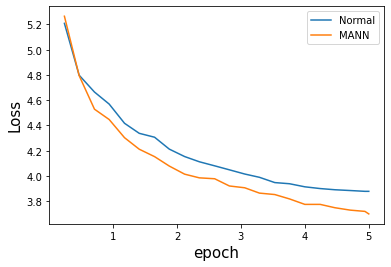

In [119]:
plotit(epoch,loss,loss1,"Loss")
#plt.legned()

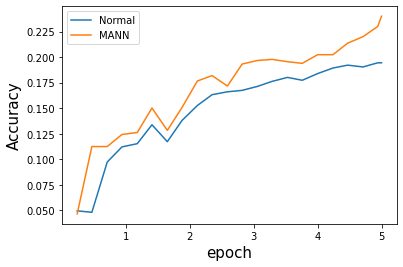

In [120]:
plotit(epoch,acc,acc1,"Accuracy")

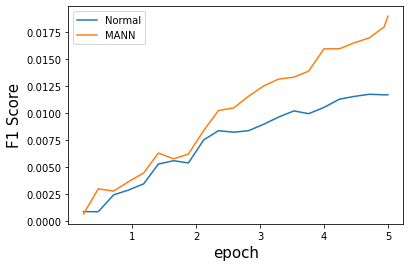

In [121]:
plotit(epoch,f1,f11,"F1 Score")

In [88]:
y=[{'eval_loss': 5.264575481414795, 'eval_acc': 0.046536224219989424, 'eval_f1': 0.0006601063440304489, 'eval_runtime': 386.4205, 'eval_samples_per_second': 14.681, 'eval_steps_per_second': 0.919, 'epoch': 0.24},
{'eval_loss': 4.7950310707092285, 'eval_acc': 0.11246254186497444, 'eval_f1': 0.002987042130348641, 'eval_runtime': 165.8962, 'eval_samples_per_second': 34.196, 'eval_steps_per_second': 2.14, 'epoch': 0.47},
{'eval_loss': 4.52902364730835, 'eval_acc': 0.11246254186497444, 'eval_f1': 0.0027777302127116846, 'eval_runtime': 165.2521, 'eval_samples_per_second': 34.329, 'eval_steps_per_second': 2.148, 'epoch': 0.71},
{'eval_loss': 4.447103977203369, 'eval_acc': 0.12427287149656266, 'eval_f1': 0.0036374169317293383, 'eval_runtime': 166.9132, 'eval_samples_per_second': 33.988, 'eval_steps_per_second': 2.127, 'epoch': 0.94},
{'eval_loss': 4.303365230560303, 'eval_acc': 0.12621188083906223, 'eval_f1': 0.004454259099749972, 'eval_runtime': 166.2724, 'eval_samples_per_second': 34.119, 'eval_steps_per_second': 2.135, 'epoch': 1.18},
{'eval_loss': 4.212154388427734, 'eval_acc': 0.1501850872554204, 'eval_f1': 0.006299758177471788, 'eval_runtime': 165.3387, 'eval_samples_per_second': 34.311, 'eval_steps_per_second': 2.147, 'epoch': 1.41},
{'eval_loss': 4.153379440307617, 'eval_acc': 0.12832716375815265, 'eval_f1': 0.005769374244900617, 'eval_runtime': 165.772, 'eval_samples_per_second': 34.222, 'eval_steps_per_second': 2.141, 'epoch': 1.65},
{'eval_loss': 4.078769683837891, 'eval_acc': 0.15071390798519302, 'eval_f1': 0.006219529207445939, 'eval_runtime': 165.0648, 'eval_samples_per_second': 34.368, 'eval_steps_per_second': 2.151, 'epoch': 1.88},
{'eval_loss': 4.014678478240967, 'eval_acc': 0.17662612374405076, 'eval_f1': 0.008397311102027662, 'eval_runtime': 164.9026, 'eval_samples_per_second': 34.402, 'eval_steps_per_second': 2.153, 'epoch': 2.12},
{'eval_loss': 3.985509157180786, 'eval_acc': 0.18191433104177684, 'eval_f1': 0.010253292296915443, 'eval_runtime': 168.8937, 'eval_samples_per_second': 33.589, 'eval_steps_per_second': 2.102, 'epoch': 2.35},
{'eval_loss': 3.978311538696289, 'eval_acc': 0.17169046359950643, 'eval_f1': 0.010499525763065974, 'eval_runtime': 165.2563, 'eval_samples_per_second': 34.328, 'eval_steps_per_second': 2.148, 'epoch': 2.59},
{'eval_loss': 3.9211161136627197, 'eval_acc': 0.19319583994359246, 'eval_f1': 0.011573960960646787, 'eval_runtime': 163.9487, 'eval_samples_per_second': 34.602, 'eval_steps_per_second': 2.165, 'epoch': 2.82},
{'eval_loss': 3.906909704208374, 'eval_acc': 0.19672131147540983, 'eval_f1': 0.012543676969140424, 'eval_runtime': 163.7395, 'eval_samples_per_second': 34.647, 'eval_steps_per_second': 2.168, 'epoch': 3.06},
{'eval_loss': 3.864691734313965, 'eval_acc': 0.19777895293495504, 'eval_f1': 0.013166336893199373, 'eval_runtime': 159.4652, 'eval_samples_per_second': 35.575, 'eval_steps_per_second': 2.226, 'epoch': 3.29},
{'eval_loss': 3.8533003330230713, 'eval_acc': 0.19548739643927376, 'eval_f1': 0.013349775347083974, 'eval_runtime': 158.7347, 'eval_samples_per_second': 35.739, 'eval_steps_per_second': 2.236, 'epoch': 3.53},
{'eval_loss': 3.818713903427124, 'eval_acc': 0.19390093424995594, 'eval_f1': 0.01390370345746792, 'eval_runtime': 158.9296, 'eval_samples_per_second': 35.695, 'eval_steps_per_second': 2.234, 'epoch': 3.76},
{'eval_loss': 3.7754194736480713, 'eval_acc': 0.20236206592631764, 'eval_f1': 0.015978237034879463, 'eval_runtime': 158.5599, 'eval_samples_per_second': 35.778, 'eval_steps_per_second': 2.239, 'epoch': 4.0},
{'eval_loss': 3.7490108013153076, 'eval_acc': 0.21364357482813326, 'eval_f1': 0.016522119419497033, 'eval_runtime': 158.4902, 'eval_samples_per_second': 35.794, 'eval_steps_per_second': 2.24, 'epoch': 4.24}]

In [105]:
loss1=[]
acc1=[]
f11=[]
epoch1=[]
for item in y:
    loss1.append(item['eval_loss'])
    acc1.append(item['eval_acc'])
    f11.append(item['eval_f1'])
    epoch1.append(item['epoch'])

In [136]:
def featurizeImage(image_encoder, img_path, device) -> Dict:
    featurizer = AutoFeatureExtractor.from_pretrained(image_encoder)
    processed_images = featurizer(
            images=[Image.open(img_path).convert('RGB')],
            return_tensors="pt",
        )
    return {
        "pixel_values": processed_images['pixel_values'].to(device),
    }

In [137]:
featurized_img = featurizeImage("google/vit-base-patch16-224-in21k", "dataset/images/image1.png", device)

loading configuration file preprocessor_config.json from cache at /Users/soumya_patra/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/7cbdb7ee3a6bcdf99dae654893f66519c480a0f8/preprocessor_config.json
loading configuration file config.json from cache at /Users/soumya_patra/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/7cbdb7ee3a6bcdf99dae654893f66519c480a0f8/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.24.0"
}

Feature extractor ViTFeat

In [140]:
featurized_img['pixel_values'].size()

torch.Size([1, 3, 224, 224])